# Projeto da disciplina de Introdução à Ciência de Dados

Estudante: Fernando de Barros (fbwn@cin.ufpe.br)

## Especificação do Projeto 1
1. Coletar Dados
2. Pré-processamento
    1. definição de tipos (pre-proc 1)
    2. tratar dados ausentes (pre-proc 1)
    3. normalização e discretização (pre-proc 1)
    4. limpeza de dados (uni, bi e multivariado)
3. Apresentar Estatisticas descritivas dos dados (com visualizações)
4. Realizar teste de hipótese para comparação de valores de categorias e visualizar diferenças

## TODO List
[ ] Organizar o que já existe para apresentação

[ ] Marcar minhas contribuições

[ ] Listar o que falta para cumprir a especificação

[ ] Deixar a abertura de arquivos mais "clean"

[ ] Deixar a navegação por rows na forma nativa e não via for-index

[ ] Adicionar validação de mínimo de pontos ao final da create_sentences

## Carregamento das Bibliotecas e do Dataset

In [1]:
import math
import sys  
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from geopy.distance import geodesic


# Sentences
sys.path.insert(0, '../building_trajectories/')
import sentences
#%run '../building_trajectories/sentences.py'

#Spark
import findspark
findspark.init("../venvTraj/lib64/python3.8/site-packages/pyspark/")
from pyspark import SparkContext

# Bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors, OSM, CARTODBPOSITRON, WIKIMEDIA

pd.set_option('display.max_columns', None)

## Inicialização de variaveis para o Bokeh
output_notebook()
tile_provider = OSM
colors=['red','blue', 'black', 'yellow']


Loading BokehJS ...

## Dublin Bus GPS sample data from Dublin City Council (Insight Project)

Bus GPS Data Dublin Bus GPS data across Dublin City, from Dublin **City Council'traffic control**, in csv format. 

Each datapoint (row in the CSV file) has the following entries:

- Timestamp micro since 1970 01 01 00:00:00 GMT  
- Line ID  
- Direction  
- Journey Pattern ID  
- Time Frame (The start date of the production time table - in Dublin the production time table starts at 6am and ends at 3am)  
- Vehicle Journey ID (A given run on the journey pattern)  
- Operator (Bus operator, not the driver)  
- Congestion [0=no,1=yes]  
- Lon WGS84  
- Lat WGS84
- Delay (seconds, negative if bus is ahead of schedule)  
- Block ID (a section ID of the journey pattern)  
- Vehicle ID  
- Stop ID  
- At Stop [0=no,1=yes]

Fonte: https://data.gov.ie/dataset/dublin-bus-gps-sample-data-from-dublin-city-council-insight-project


### Abre arquivo referente aos dias 10~12 de Janeiro de 2013

### Colunas originais do dataset

In [2]:
features = ['timestamp','line_id','direction','journey_id',
            'time_frame','vehicle_journey_id','operator',
            'congestion','lng','lat','delay','block_id',
            'vehicle_id','stop_id', 'stop']

In [3]:
df = pd.read_csv(
    '../data/siri.20130110.csv.gz', 
    compression='gzip', 
    names=features, 
    header=None)
for i in tqdm(range(20130111,20130112,1)):
    data = pd.read_csv(
        '../data/siri.'+str(i)+'.csv.gz', 
        compression='gzip', 
        names=features, 
        header=None)
    df = pd.concat([df,data])

100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


### Lista com nomes das colunas que formam a chave da trajetória

In [4]:
trajetoria = ['line_id','journey_id','time_frame','vehicle_journey_id','operator','vehicle_id']

### Novas features que serão alimentadas junto à criação das trajetórias

In [5]:
df['velocity'] = 0
df['acc'] = 0
df['dist_from_old_point'] = 0
df['time_from_old_point'] = 0
df['MF_lat'] = 0 
df['MF_lng'] = 0
df['MF_velocity'] = 0
df['MF_acc'] = 0
df['MF_dist_from_old_point'] = 0

## Análise inicial do dataset

In [6]:
df.head()

,timestamp,line_id,direction,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,MF_lat,MF_lng,MF_velocity,MF_acc,MF_dist_from_old_point
0,1357776002000000,31.0,0,NaN,2013-01-09,5509,CF,0,-6.257756,53.349159,0,31008,38075,296.0,0,0,0,0,0,0,0,0,0,0
1,1357776002000000,66.0,0,066A0001,2013-01-09,2390,PO,0,-6.406750,53.357983,-101,66001,33376,3993.0,0,0,0,0,0,0,0,0,0,0
2,1357776002000000,49.0,0,00491001,2013-01-09,2837,RD,0,-6.272375,53.341053,-149,49006,33483,2383.0,0,0,0,0,0,0,0,0,0,0
3,1357776002000000,14.0,0,00141001,2013-01-09,5452,SL,0,-6.251083,53.357666,-251,14101,33113,248.0,1,0,0,0,0,0,0,0,0,0
4,1357776002000000,40.0,0,040D0001,2013-01-09,2217,HN,0,-6.390792,53.422108,-478,40203,38071,7104.0,0,0,0,0,0,0,0,0,0,0


In [7]:
df.tail()

,timestamp,line_id,direction,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,MF_lat,MF_lng,MF_velocity,MF_acc,MF_dist_from_old_point
1729769,1357948798000000,83.0,0,00830001,2013-01-11,5776,HN,0,-6.302700,53.318638,-144,83011,40020,2489.0,0,0,0,0,0,0,0,0,0,0
1729770,1357948798000000,39.0,0,NaN,2013-01-11,3175,PO,0,-6.244823,53.328770,170,39020,36054,767.0,0,0,0,0,0,0,0,0,0,0
1729771,1357948798000000,15.0,0,00151001,2013-01-11,5112,HN,0,-6.152171,53.402569,503,15105,33502,7245.0,1,0,0,0,0,0,0,0,0,0
1729772,1357948798000000,272.0,0,027B0002,2013-01-11,369,HN,0,-6.276100,53.418041,129,272005,33504,1629.0,0,0,0,0,0,0,0,0,0,0
1729773,1357948798000000,39.0,0,00391001,2013-01-11,3020,PO,0,-6.252700,53.331966,-486,39010,36061,7339.0,1,0,0,0,0,0,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3430406 entries, 0 to 1729773
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   timestamp               int64  
 1   line_id                 float64
 2   direction               int64  
 3   journey_id              object 
 4   time_frame              object 
 5   vehicle_journey_id      int64  
 6   operator                object 
 7   congestion              int64  
 8   lng                     float64
 9   lat                     float64
 10  delay                   int64  
 11  block_id                int64  
 12  vehicle_id              int64  
 13  stop_id                 float64
 14  stop                    int64  
 15  velocity                int64  
 16  acc                     int64  
 17  dist_from_old_point     int64  
 18  time_from_old_point     int64  
 19  MF_lat                  int64  
 20  MF_lng                  int64  
 21  MF_velocity             int64  

In [9]:
df.describe()

,timestamp,line_id,direction,vehicle_journey_id,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,MF_lat,MF_lng,MF_velocity,MF_acc,MF_dist_from_old_point
count,3.430406e+06,3.429963e+06,3430406.0,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.430406e+06,3.236571e+06,3.430406e+06,3430406.0,3430406.0,3430406.0,3430406.0,3430406.0,3430406.0,3430406.0,3430406.0,3430406.0
mean,1.357871e+15,7.674974e+01,0.0,8.030546e+03,1.081942e-02,-6.271851e+00,5.334449e+01,-1.286452e+01,1.157287e+05,3.534091e+04,2.755840e+03,2.306231e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4.666748e+10,1.110898e+02,0.0,6.354814e+04,1.034522e-01,8.350831e-02,5.512406e-02,4.634146e+02,2.029284e+05,3.250063e+03,2.187218e+03,4.212317e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.357776e+15,1.000000e+00,0.0,1.000000e+00,0.000000e+00,-6.615016e+00,5.307028e+01,-7.334000e+03,1.001000e+03,2.804700e+04,2.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.357828e+15,2.500000e+01,0.0,2.007000e+03,0.000000e+00,-6.307797e+00,5.331963e+01,-1.880000e+02,1.602100e+04,3.329100e+04,8.330000e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.357885e+15,4.000000e+01,0.0,3.856000e+03,0.000000e+00,-6.261396e+00,5.334624e+01,0.000000e+00,4.021000e+04,3.351400e+04,2.101000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.357914e+15,8.300000e+01,0.0,5.520000e+03,0.000000e+00,-6.232217e+00,5.337394e+01,1.290000e+02,1.020050e+05,3.801000e+04,4.411000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.357949e+15,7.470000e+02,0.0,9.997110e+05,1.000000e+00,-6.052917e+00,5.360655e+01,1.161220e+05,8.350020e+05,4.307800e+04,7.552000e+03,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Retirar a coluna DIRECTION que não apresenta qualquer informação

In [10]:
df.drop('direction', axis=1, inplace=True)
'direction' in df.columns

False

Indicar quais das colunas são categoricas:

In [11]:
list_cats = ['line_id', 'journey_id' , 'time_frame', 
             'vehicle_journey_id', 'operator', 'block_id', 
             'vehicle_id', 'stop_id']

### Ajusta tipo das features

#### Boolean

In [12]:
df.stop = df.stop.astype('bool')
df.congestion = df.congestion.astype('bool')

#### Datetime (microseconds - us)

In [13]:
df['datetime'] = pd.to_datetime(df["timestamp"], unit='us')

##### Criação de duas novas features derivadas (day, hour)

In [14]:
df['hour'] = df["datetime"].dt.hour
df['day'] = df["datetime"].dt.day

### Descrição das chaves para criação de trajetórias

In [15]:
lista_tamanhos = map((lambda x: len(df[x].unique())), trajetoria)
mescla = zip(trajetoria, lista_tamanhos)
print('Descritivo de instâncias únicas para cada atributo da chave:')
tuple(mescla)

Descritivo de instâncias únicas para cada atributo da chave:


(('line_id', 66),
 ('journey_id', 441),
 ('time_frame', 3),
 ('vehicle_journey_id', 7495),
 ('operator', 8),
 ('vehicle_id', 850))

### Como o 'prodution time' é entre 6am e 3am. Existem rotas fora desta janelas?

In [16]:
df[(3 < df.hour) & (df.hour < 6)]

,timestamp,line_id,journey_id,time_frame,vehicle_journey_id,operator,congestion,lng,lat,delay,block_id,vehicle_id,stop_id,stop,velocity,acc,dist_from_old_point,time_from_old_point,MF_lat,MF_lng,MF_velocity,MF_acc,MF_dist_from_old_point,datetime,hour,day


## Análisar trajetórias

In [17]:
df_traj = df.groupby(trajetoria).size().reset_index()
df_traj['points'] = df_traj[0]
df_traj.drop(0, axis=1, inplace=True)

In [18]:
df_traj.head()

,line_id,journey_id,time_frame,vehicle_journey_id,operator,vehicle_id,points
0,1.0,00010001,2013-01-10,4304,RD,43072,1
1,1.0,00010001,2013-01-10,4305,RD,43072,1
2,1.0,00010001,2013-01-10,4306,RD,43072,2
3,1.0,00010001,2013-01-10,4307,RD,43072,1
4,1.0,00010001,2013-01-10,4308,RD,43072,1


In [19]:
df_traj.points.describe()

count    25840.000000
mean       113.391370
std        113.703676
min          1.000000
25%          1.000000
50%        105.000000
75%        207.250000
max        875.000000
Name: points, dtype: float64

<AxesSubplot:>

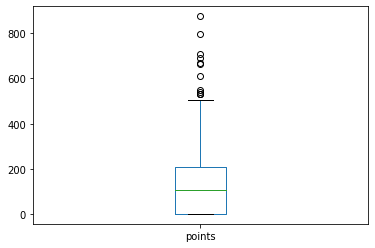

In [20]:
df_traj.points.plot(kind='box')

<AxesSubplot:ylabel='Frequency'>

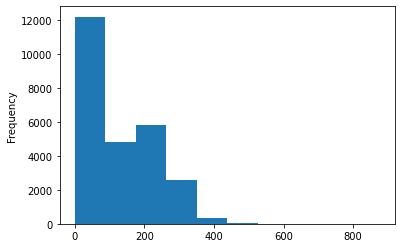

In [21]:
df_traj.points.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

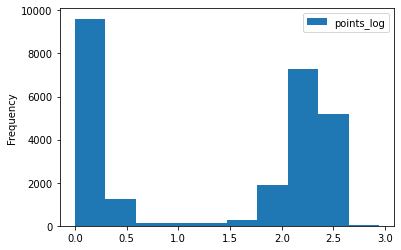

In [22]:
df_traj['points_log'] = np.log10(df_traj['points'])
df_traj.plot(y='points_log', kind='hist')

In [23]:
df_traj.points_log.describe()

count    25840.000000
mean         1.309341
std          1.105556
min          0.000000
25%          0.000000
50%          2.021189
75%          2.316494
max          2.942008
Name: points_log, dtype: float64

Observamos uma partição dos número de pontos por trajetória um pouco abaixo de 100 pontos. Mais a frente iremos usar o valor limite de 50 pontos para excluir as trajetórias abaixo deste limiar.

In [24]:
minimo_pontos = 50

## Gerar trajetórias

Na função que gera trajetórias incluimos algumas features aproveitando o fato de que esta geração de trajetórias percorre o dataset linha a linha, uma vez que precisamos identificar um valor limite entre duas amostras do GPS para poder validar a trajetória. Usamos aqui o valor é de 5 minutos.

In [25]:
[1,2,3].remove

<function list.remove(value, /)>

In [26]:
tuple([1,2])

(1, 2)

In [27]:
l = np.array(5* [(1,1),])

for x, y in zip((1,2,3), (4,5,6)):
    l = np.array([*l[1:], tuple([x,y])])
    
    print(l.mean(axis=0))

[1.  1.6]
[1.2 2.4]
[1.6 3.4]


In [28]:
x = list(range(10))
xx = pd.DataFrame(data={'a':x, 'b':x})
xx['xa'] = x['a']
xx['xa'] = x['a']

TypeError: list indices must be integers or slices, not str

In [ ]:
x1 = pd.DataFrame(data={'a':[1], 'b': [2]})
ac = x1.iloc[0]
x1

ac.a = 50
ac
x1

In [ ]:
## Função resp. pela criação de sentenças/trajetórias

### Funções auxiliares

def not_window(time):
    return time > 5 * 60

def delta_time(t1, t2) -> float:
    ##Return time difference between time in seconds
    t1 = pd.to_datetime(t1,unit='us')
    t2 = pd.to_datetime(t2,unit='us')
    time = pd.Timedelta(np.abs(t2 - t1))
    return time.seconds


### Função principal
filter_N = 5

def create_sentences2(data, trajectory_features, idx):
    ## Aqui caberia transformar a análise em um serie temporal???
    data = data.sort_values('timestamp')
    # Seleciona ponto zero (inicio da rota)
    point = data.iloc[0]
    old_time = point['timestamp']
    old_position = point[['lat','lng']].values
    # Utilização de Mean Filter (MF) para eliminar ruídos
    initial_filter = np.array(old_position)
    point['MF_lat'] = point['lat']
    point['MF_lng'] = point['lng']
    MF_old_position = old_position
    num_points = 0
    #for index in tqdm(data.index):
    for index, row in data.iloc[1:].iterrows():
    #for index in data.index:
        # calculo da diferença de tempo
        actual_time = row['timestamp']
        row['time_from_old_point'] = time = delta_time(old_time, actual_time)
        # Marca a etiqueta -1 para posterior remoção de trajetória que não possuem um mínimo de pontos
        # e não atendem à janela temporal entre pontos
        #if (~is_window(time) & (num_points < minimo_pontos)):
        if (not_window(time)):
            #TODO#
            data['idx'] = -1
            return data
        #FI
        # calculo da diferença espacial
        actual_position = row[['lat','lng']].values
        space = geodesic(old_position, actual_position).meters
        row.dist_from_old_point = space
        ## idem para MF
        ### Add (lat, lng) no vetor para tirar a média posterior
        if (len(initial_filter) < filter_N):
            initial_filter = np.array([*initial_filter, actual_position])
        else:
            initial_filter = np.array([*initial_filter[1:], tuple(actual_position)])
        #FI
        #print (initial_filter)
        #print(initial_filter.mean(axis=0)[0])
        #input()
        row['MF_lat'] = initial_filter.mean(axis=0)[0]
        row['MF_lng'] = initial_filter.mean(axis=0)[1]
        MF_actual_position = row[['MF_lat','MF_lng']].values
        MF_space = geodesic(MF_old_position, MF_actual_position).meters
        row['MF_dist_from_old_point'] = MF_space
        # evita divisão por zero e atribui mantem o valor default nulo (0).
        # uma vez que se não há variação no timestamp da amostra, 
        # não haverá de velocidade e aceleração também
        if (time != 0):
            row['velocity'] = space / time
            row['acc'] = space / (time * time)
            # MF
            row['MF_velocity'] = MF_space / time
            row['MF_acc'] = MF_space / (time * time)
        #FI
        data.loc[index] = row
        old_time = actual_time
        old_position = actual_position
        MF_old_position = MF_actual_position
        num_points += 1
    # ao final toda a trajetória recebe o mesmo ID criado dentro do loop que chama esta função
    data['idx'] = idx
    return data

No agrupamento a seguir todas as instâncias com uma das features listadas como chave com valor NaN é descartada.

In [ ]:
dfs = [x for _,x in df.groupby(trajetoria) if (len(x) > minimo_pontos)]

In [ ]:
#backup
df0 = df.copy()

In [ ]:
df = df0
num_trajetorias = 50
# esta variavel será o gerador das IDs de trajetorias
ID = range(num_trajetorias)
#print(len(dfs[:num_trajetorias]))
#print(len(ID))
df = map(lambda x, i: create_sentences2(x, trajetoria, i), dfs[:num_trajetorias], ID)
df = pd.concat(list(df))
df = df[df.idx != -1]

In [ ]:
df.head()

In [ ]:
df[df.idx==0][['lat','lng','MF_lat','MF_lng']].head(20)

In [ ]:
new_cols = ['time_from_old_point',
            'velocity', 'acc', 'dist_from_old_point',
            'MF_velocity', 'MF_acc', 'MF_dist_from_old_point']
df[new_cols].describe()

In [ ]:
df[new_cols].plot(kind='box', figsize=(10,6))

In [ ]:
list_cats = ['line_id', 'journey_id' , 'time_frame', 'vehicle_journey_id', 'operator' ]
for cat in list_cats:
    df[cat] = df[cat].astype('category')
    #df[cat] = df[cat].cat.codes

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
feats = ['velocity','acc']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats])
scores = clf.predict(df[feats])
df['outlier'] = scores

In [ ]:
MF_feats = ['MF_velocity','MF_acc']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats])
scores = clf.predict(df[feats])
df['MF_outlier'] = scores

In [ ]:
df[df.outlier == 1][feats].describe()

In [ ]:
df[df.MF_outlier == 1][MF_feats].describe()

In [ ]:
df[df.outlier == 1][feats].hist()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor


In [ ]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df[feats])
df['outlier2'] = scores

In [ ]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df[MF_feats])
df['MF_outlier2'] = scores

In [ ]:
df[df.outlier2 == 1][feats].describe()

In [ ]:
df[df.MF_outlier2 == 1][MF_feats].describe()

Testar se Isolation Forest funciona sem velocidade e aceleração

In [ ]:
feats_loc = ['dist_from_old_point','time_from_old_point']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[feats_loc])
scores = clf.predict(df[feats_loc])
df['outlier3'] = scores

In [ ]:
MF_feats_loc = ['MF_dist_from_old_point','time_from_old_point']
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df[MF_feats_loc])
scores = clf.predict(df[MF_feats_loc])
df['MF_outlier3'] = scores

In [ ]:
df[df.outlier3 == 1][feats_loc].describe()

In [ ]:
df[df.MF_outlier3 == 1][MF_feats_loc].describe()

In [ ]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df[feats_loc])
df['outlier4'] = scores

In [ ]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
scores = clf.fit_predict(df[MF_feats_loc])
df['MF_outlier4'] = scores

In [ ]:
df[df.outlier4 == 1][feats_loc].describe()

In [ ]:
df[df.MF_outlier4 == 1][MF_feats_loc].describe()

In [ ]:
df1 = df[df.outlier==1]

In [ ]:
df1[feats].plot()

In [ ]:
!pip install seaborn
import seaborn as sns                                              

In [ ]:
sns.histplot(x=df1[df1.acc!=0].acc.apply(np.log10))


In [ ]:
sns.histplot(x=df1[df1.velocity!=0].velocity.apply(np.log10))

In [ ]:
from scipy import stats

In [ ]:
list_hours = [0,2,6,8,10,12,14,16,18,20,22 ]
df2 = df1[df1.velocity !=0]
for h in list_hours:
    print(h)
    print(stats.mannwhitneyu(df2[df2.hour <= h].velocity, df2[df2.hour > h].velocity))
df2 = df1[df1.acc !=0]
for h in list_hours:
    print(h)
    print(stats.mannwhitneyu(df2[df2.hour <= h].acc, df2[df2.hour > h].acc))

In [ ]:
stats.mannwhitneyu(df2[df2.hour <= 12].velocity, df2[df2.hour > 12].velocity)


In [ ]:
stats.mannwhitneyu(df[df.hour <= 12].velocity, df[df.hour > 12].velocity)

In [ ]:
df[df.acc!=0].acc.apply(np.log10).plot(kind='hist', density=True)

In [ ]:
pd.plotting?

In [ ]:
df[df.acc!=0].acc.apply(np.log10).hist

In [ ]:
df[df.velocity!=0].velocity.apply(np.log10).hist()

In [ ]:
df['acc_log'] = np.log(df.acc)


In [ ]:
df[df.acc!=0].acc.hist()

In [ ]:
df[df.velocity == df.velocity.max()].idx

In [ ]:
df[df.idx==85].velocity.describe()

In [ ]:
velINF = df[df.velocity>20].idx.unique()

In [ ]:
df = df[~ df['idx'].isin(velINF)]

In [ ]:
df.velocity.max()

In [ ]:
df.velocity.hist()

Grupos pontos capturados antes e depois do meio-dia.

In [ ]:
stats.mannwhitneyu(df[df.operator == 'CD'].velocity, df[df.operator != 'CD'].velocity)

In [ ]:
df['vel_log'] = np.log(df.velocity)

In [ ]:
df[df.velocity != 0].vel_log.hist()

In [ ]:
df[df.velocity ==df.velocity.max()]

In [ ]:
df.lng.hist()

In [ ]:
df.datetime_hour.plot(kind='box')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#df_norm = pd.DataFrame(, columns=df_cars.columns)
#df_norm

pd.DataFrame(scaler.fit_transform(df[['timestamp','velocity']]), columns = ['timestamp', 'velocity'])

In [ ]:
scaler.fit_transform(df['timestamp'].values.reshape(-1,1))

In [ ]:
from scipy import stats
stats.shapiro(df[df.datetime_hour > 12].velocity)

In [ ]:
df['vel_sqrt'] = np.sqrt(df.velocity)
stats.shapiro(df[df.datetime_hour > 12].vel_sqrt)

In [ ]:
dfs2.vel_log.hist()

In [ ]:
df[['vel_man', 'vel_tar']].plot(kind='box')

In [ ]:
df[['vel_man', 'vel_tar']].plot(kind='box')

In [ ]:
df['vel_log'] = np.log(df.velocity)

In [ ]:
36*

In [ ]:
df[df.velocity ==df.velocity.max()]

In [ ]:
delta = delta_time(1357814590000000, 1357814592000000)
#            actual_position = data.loc[index][['lat','lng']].values
#            space = geodesic(old_position, actual_position).meters
delta

In [ ]:
space = geodesic([53.355534,-6.264616], [53.353451, -6.262167]).meters
#space = geodesic([-6.264616,53.355534], [-6.262167,53.353451]).meters

space

In [ ]:
df[df.idx == 0].loc[525000:525633]

In [ ]:
df[df.idx==85].datetime.describe()

In [ ]:
df[df.velocity == df.velocity.max()]

In [ ]:
df[df.dist_from_old_point==df.dist_from_old_point.max()]

In [ ]:
df.idx.unique()

In [ ]:
data_line = df[df.idx == 49]

def to_mercator(Coords):
    Coordinates =  Coords
    #literal_eval(Coords)    
    
    lat = Coordinates[1]
    lon = Coordinates[0]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale    
    
    return pd.Series((x, y))

def plot_fig(df_x, color):
    p = figure(x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(get_provider(tile_provider))
    #p.circle(
    p.line(
        x='lng_m',
        y='lat_m',
        color= color,
        source=df_x
    )
    p.circle(
        x='lng_m',
        y='lat_m',
        color= 'red',
        source=df_x[df_x.outlier == -1]
    )
    p.circle(
        x=df_x.iloc[0]['lng_m'],
        y=df_x.iloc[0]['lat_m'],
        color= 'blue',    
    )
    return (p)


p = figure(x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(get_provider(tile_provider))

data_line[['lng_m','lat_m']] = data_line[['lng', 'lat']].apply(to_mercator, axis=1)

p = plot_fig(data_line, 'black')

show(p)